Импорт библиотек
---

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Загрузка и базовая обработка данных
---

In [2]:
# Загружаем обучающие данные
images = np.load('images.npy')
labels = np.load('labels.npy')

# Проверим размерность
print(f"Обучающая выборка: {images.shape}, Метки: {labels.shape}")

# Нормализация изображений
images = images.astype('float32') / 255.0

Обучающая выборка: (20000, 48, 48, 3), Метки: (20000,)


Загружаем данные и сразу приводим их к нужному формату — значения пикселей в диапазон [0,1]

Разделение на train и validation
---

In [3]:
# Для контроля качества выделяем небольшую валидационную выборку
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.1, random_state=42)

Отделяем 10% от обучения на проверку качества модели.

Аугментация данных
---

In [4]:
# Генератор с аугментациями
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.15
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

Аугментации помогают сети видеть различные варианты букв — ключ к хорошей обобщающей способности.

Архитектура нейронной сети
---

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 3)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(26, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Компиляция модели
---

In [6]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Это задача классификации изображений - Adam Совмещает RMSProp + Momentum + адаптивность.


categorical_crossentropy — классический loss для классификации

Вместе они дают "хорошую" скорость сходимости и высокую точность




Обучение
---

In [7]:
batch_size = 64
epochs = 25

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=val_datagen.flow(X_val, y_val),
    epochs=epochs
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 485s 2s/step - accuracy: 0.0495 - loss: 3.2373 - val_accuracy: 0.2330 - val_loss: 2.6407
Epoch 2/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 507s 2s/step - accuracy: 0.2453 - loss: 2.5678 - val_accuracy: 0.5685 - val_loss: 1.4938
Epoch 3/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 481s 2s/step - accuracy: 0.4546 - loss: 1.8342 - val_accuracy: 0.6495 - val_loss: 1.1563
Epoch 4/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 481s 2s/step - accuracy: 0.5362 - loss: 1.5236 - val_accuracy: 0.7385 - val_loss: 0.9082
Epoch 5/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 481s 2s/step - accuracy: 0.5825 - loss: 1.3602 - val_accuracy: 0.7515 - val_loss: 0.8223
Epoch 6/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 487s 2s/step - accuracy: 0.6234 - loss: 1.2137 - val_accuracy: 0.7570 - val_loss: 0.7706
Epoch 7/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 480s 2s/step - accuracy: 0.6510 - loss: 1.1131 - val_accuracy: 0.7840 - val_loss: 0.6913
Epoch 8/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 479s 2s/step - accuracy: 0.6818 - loss: 1.0330 - val_accu

Я увеличил количество эпох для стабильной сходимости и чтобы получить хороший результат в kaggle, runtime больше чем 2 часа, уже не уверен что Adam и categorical_crossentropy действительно правельный выбор.

Загрузка теста и предсказание
---

In [8]:
# Загрузка тестового набора
images_sub = np.load('images_sub.npy')
images_sub = images_sub.astype('float32') / 255.0

# Предсказания
preds = model.predict(images_sub)
preds_classes = np.argmax(preds, axis=1)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 347s 222ms/step


Делаем то же, что и для train — нормализация и предсказание классов

Итог и визуализация
---

In [11]:
preds_classes = np.argmax(preds, axis=1).astype(int)
submission = pd.DataFrame({
    'id': np.arange(len(preds_classes)),
    'Category': preds_classes
})
submission.to_csv('submission.csv', index=False)

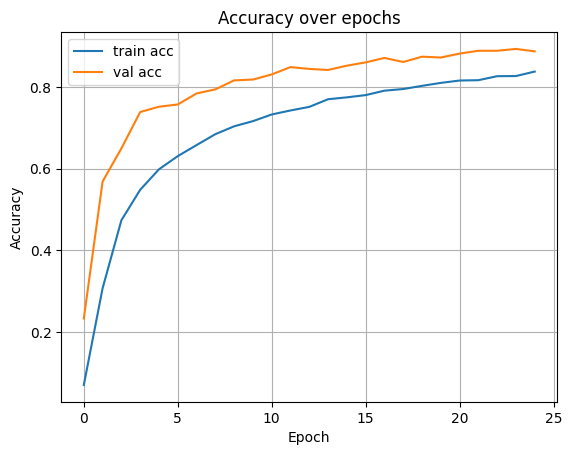

In [10]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

- Уже к 5 эпохе обе кривые выходят выше 0.7
- Начиная примерно с 3-й эпохи, оранжевая линия идёт выше синей
  признак наличия Dropout или других регуляризаций
- Потенциально можно обучать дальше т.к. две кривые не закончены.

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 271ms/step


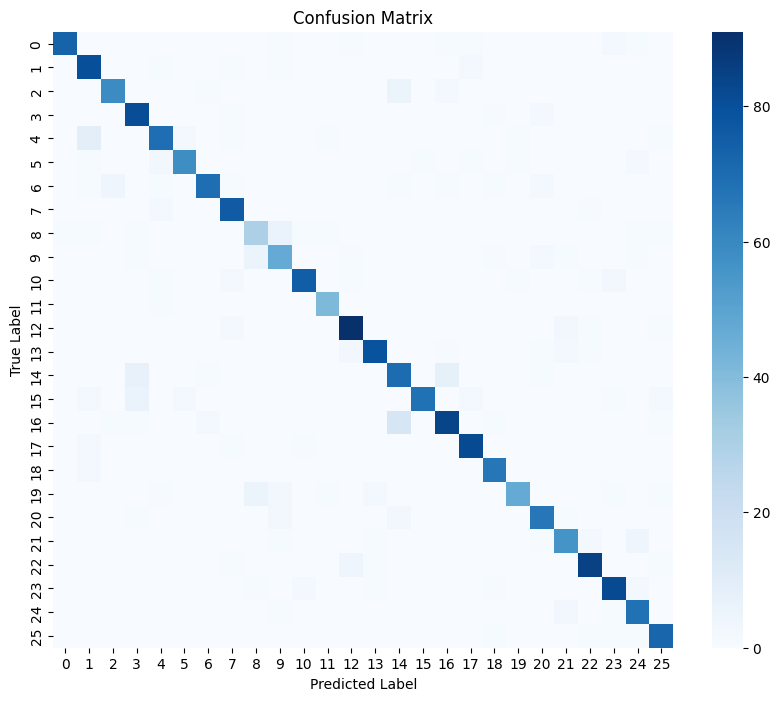

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Получаем предсказания на валидационной выборке
val_preds = model.predict(X_val)
val_preds_classes = np.argmax(val_preds, axis=1)

# Строим confusion matrix
cm = confusion_matrix(y_val, val_preds_classes)

# Красиво визуализируем
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Почти вся масса сосредоточена на диагонали а значит что модель хорошо различает классы.

In [15]:
from sklearn.metrics import classification_report

print(classification_report(y_val, val_preds_classes))

              precision    recall  f1-score   support

           0       0.99      0.91      0.95        80
           1       0.82      0.94      0.87        85
           2       0.92      0.88      0.90        67
           3       0.83      0.95      0.89        85
           4       0.87      0.82      0.85        84
           5       0.94      0.87      0.90        67
           6       0.95      0.85      0.90        81
           7       0.88      0.96      0.92        79
           8       0.73      0.70      0.71        43
           9       0.75      0.80      0.77        59
          10       0.95      0.89      0.92        84
          11       0.93      0.98      0.95        42
          12       0.90      0.93      0.91        98
          13       0.94      0.91      0.92        87
          14       0.74      0.80      0.77        87
          15       0.99      0.82      0.89        83
          16       0.87      0.80      0.83       105
          17       0.93    

---
Классы 0, 3, 7, 11, 12, 13, 17, 18, 25

    f1-score выше 0.90 — очень качественная классификация.

    Класс 0: precision 0.99 (очень редко путается с другими).
Класс 8

    (f1-score 0.71) — слабее всего:

    recall 0.70 — часто не определяет этот класс.

Скорее всего, модель путает визуально похожие символы

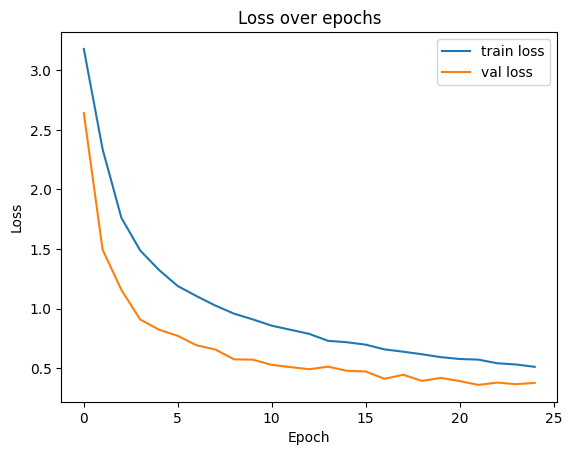

In [16]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Впринципе инвертированый график Accuracy

можно было бы обучать еще несколько эпох

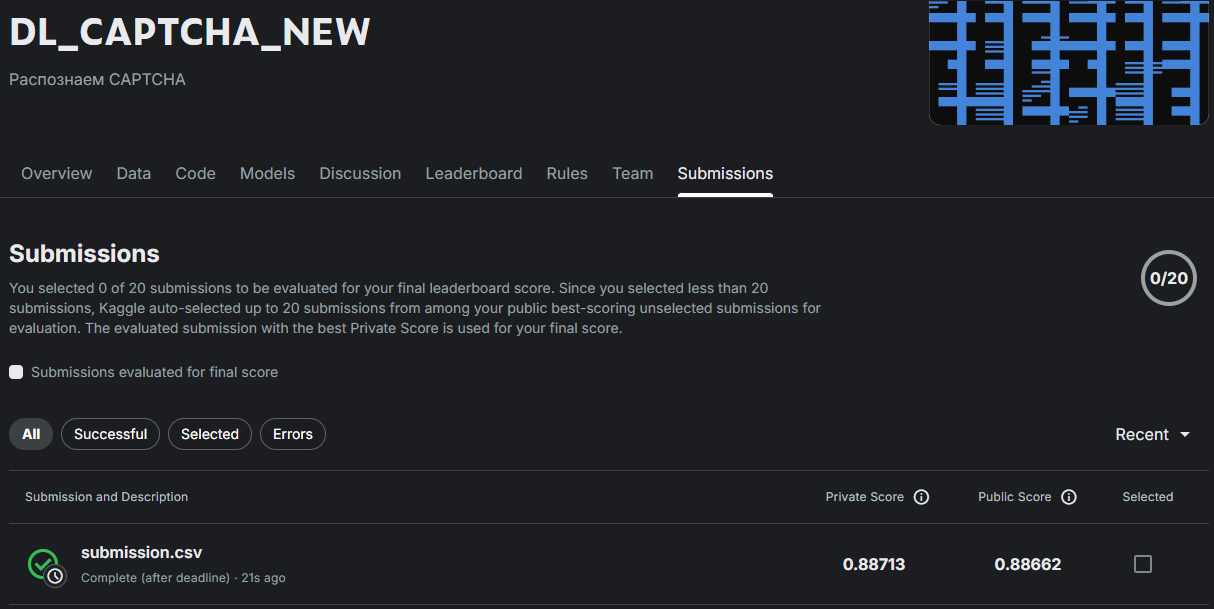